# LSST CCOB ghost basic fit to the geometry

Show a first implementation of fitting geometry to a set of ghosts catalogs

## TODO
- choose a fit technique
- implement the fit with on the fly simulation on 1 parameter
- implement the fit with on the fly simulation with several parameters but one by one recursively
- implement the fit with on the fly simulation with several parameters at once
- implement the fit with on the fly simulation with all parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize_scalar, minimize

import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import reduce_ghosts, compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1
from ghosts.geom_configs import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 9000 pixels per mm^2


### True ghosts catalog ~ real data
- Build an aligned telescope, choose one CCOB ghost config, generate ghosts catalog

In [4]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

# CCOB like geometry, i.e. lenses but no filter
ref_telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(ref_telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

0

In [5]:
# Cool ghost configuration
ref_beam = copy.deepcopy(BEAM_CONFIG_0)
ref_beam['beam_id'] = 999042
ref_beam['n_photons'] = 10000
ref_beam['x_offset'] = +0.3
ref_beam['y_offset'] = -0.55
ref_beam['x_euler'] = -17
ref_beam['y_euler'] = -6

# make a copy with less photons for the fit
fit_beam = copy.deepcopy(ref_beam)
fit_beam['n_photons'] = 1000

In [6]:
# Ray trace one config for debugging
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(ref_telescope, beam_config=ref_beam)
simulation = [trace_full, r_forward, r_reverse, rays]

# reduce ghosts
ref_spots_data, _spots = reduce_ghosts(r_forward)
ref_spots_data_frame = make_data_frame(ref_spots_data, beam_id=ref_beam['beam_id'], geom_id=0)
ref_gh_sep = compute_ghost_separations(ref_spots_data_frame)
ref_spots_data_frame.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,n_pixels,pixel_signal
12,999042,0,12,"(Detector, L2_entrance)",-0.016797,0.000496,0.312480,0.000496,0.001974,0.001947,0.000980,0.000013,4.626507,3.018593,27167,4.372196e+03
13,999042,0,13,"(Detector, L2_exit)",-0.043923,0.000161,0.218485,0.000161,0.000640,0.000541,0.000295,0.000050,4.663742,0.273868,2465,4.857850e+04
14,999042,0,14,"(Detector, L3_entrance)",0.104792,0.000568,-0.010240,0.000568,0.002263,0.002258,0.001130,0.000002,4.701277,4.012691,36114,3.342190e+03
15,999042,0,15,"(Detector, L3_exit)",0.122995,0.000622,-0.033610,0.000622,0.002478,0.002494,0.001243,0.000008,4.739115,4.852963,43677,2.785744e+03
0,999042,0,0,"(L1_exit, L1_entrance)",-0.027528,0.000244,0.211851,0.000244,0.000969,0.000756,0.000431,0.000106,0.134121,0.584391,5260,6.547045e+02
3,999042,0,3,"(L2_entrance, L1_exit)",-0.046042,0.000346,0.315325,0.000346,0.001378,0.001301,0.000670,0.000039,0.134121,1.409251,12683,2.714945e+02
1,999042,0,1,"(L2_exit, L1_entrance)",0.139649,0.000885,0.055483,0.000885,0.003524,0.003519,0.001761,0.000002,0.131988,9.738106,87643,3.866447e+01
2,999042,0,2,"(L2_exit, L1_exit)",0.257845,0.001359,-0.041885,0.001359,0.005411,0.005388,0.002700,0.000011,0.133051,22.894968,206055,1.657784e+01
4,999042,0,4,"(L2_exit, L2_entrance)",0.245669,0.001056,-0.172801,0.001056,0.004206,0.004087,0.002073,0.000060,0.134121,13.505599,121550,2.832927e+01
7,999042,0,7,"(L3_entrance, L1_entrance)",0.074586,0.000942,0.274420,0.000942,0.003749,0.003775,0.001881,0.000013,0.130935,11.117465,100057,3.359692e+01


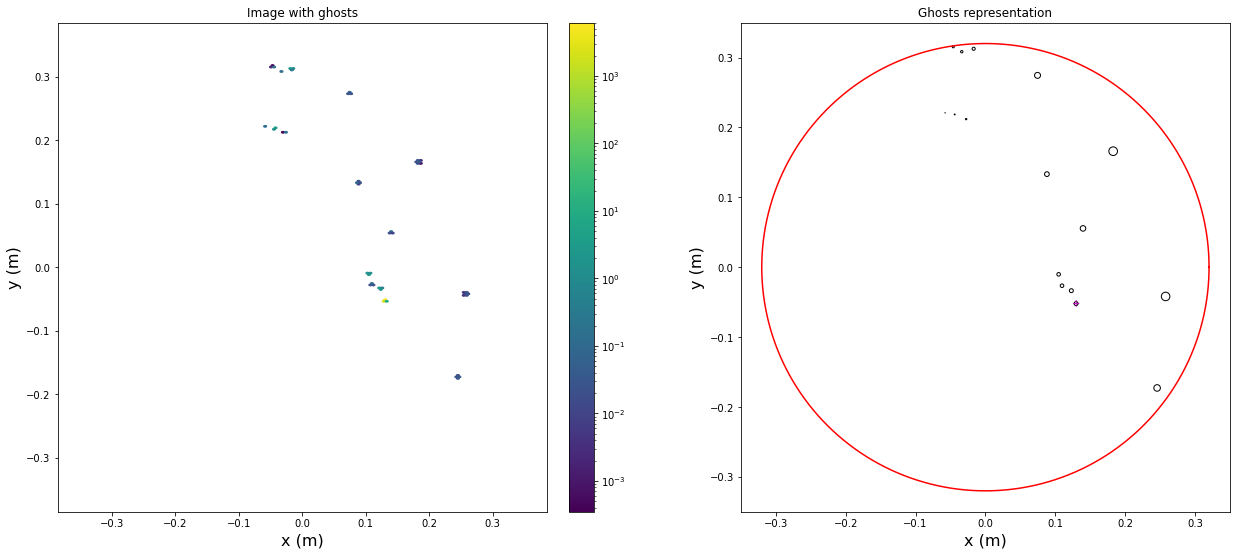

In [7]:
# plot focal plane
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, ref_spots_data_frame, log_scale=True)

### Basic fit over one lens rotation

In [8]:
def basic_build_telescope_to_fit(L1_rx):
    """ Build telescope to fit from reference telescope
    """
    # Build telescope
    fitted_geom_config = {'L1_rx': L1_rx}
    fitted_telescope = tweak_optics.tweak_telescope(ref_telescope, fitted_geom_config)
    # Make refractive interfaces partially reflective
    tweak_optics.make_optics_reflective(fitted_telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])
    return fitted_telescope


def basic_compute_distance(L1_rx):
    """ Callable function for the fit
    """
    # new telescope
    fitted_telescope = basic_build_telescope_to_fit(L1_rx)
    fit_spots_df = simulator.run_and_analyze_simulation(fitted_telescope, geom_id=0, beam_config=fit_beam)
    # match ghosts
    match = match_ghosts(ref_spots_data_frame, fit_spots_df, radius_scale_factor=10)
    dist_2d = compute_2d_reduced_distance(match)
    #print(f'L1_rx={L1_rx}\tDistance={dist_2d}')
    return dist_2d


In [9]:
# Do a very basic fit using a scalar function
bounded_opts = {'maxiter':100, 'xatol':1e-7, 'disp':3}
res = minimize_scalar(basic_compute_distance, bounds=(-0.1, 0.1), method='bounded', options=bounded_opts)
print(f'\nMinimal distance is {res.fun}')
print(f'for L1 rotation around x to be L1_rx={res.x}')  # minimizer

 
 Func-count     x          f(x)          Procedure
    1     -0.0236068  0.000106318        initial
    2      0.0236068  0.000106658        golden
    3     -0.0527864  0.000244753        golden
    4   -5.78765e-05  6.87313e-06        parabolic
    5   -2.01384e-05  2.18412e-06        parabolic
    6     0.00900455  4.25906e-05        golden
    7      0.0043346  2.37687e-05        parabolic
    8     0.00207298  1.68272e-05        parabolic
    9    0.000969632  5.27347e-06        parabolic
   10    0.000462157  1.06542e-05        parabolic
   11    0.000164082  5.85783e-06        golden
   12    5.02275e-05  6.21895e-06        golden
   13    6.73897e-06   1.2609e-05        golden
   14   -3.45531e-05  4.37737e-06        golden
   15   -9.87218e-06  9.88787e-06        golden
   16   -2.56443e-05  2.99379e-06        golden
   17   -1.62171e-05  5.76518e-06        golden
   18   -2.22415e-05  6.80072e-06        golden
   19   -1.86406e-05  1.54164e-05        golden
   20   -2.09417

In [10]:
fit = """ Func-count     x          f(x)          Procedure
    1     -0.0236068  0.000106797        initial
    2      0.0236068  0.000106329        golden
    3      0.0527864  0.000243869        golden
    4    8.02143e-05  3.93155e-06        parabolic
    5    2.69311e-05  1.91557e-05        parabolic
    6      0.0116666  5.38016e-05        parabolic
    7     0.00450582  1.74659e-05        golden
    8      0.0022693  1.42141e-05        parabolic
    9    0.000916371  9.95764e-06        golden
   10    0.000399598  1.53059e-05        golden
   11    0.000202208  8.93834e-06        golden
   12    0.000126812  1.08775e-05        golden
   13    5.98619e-05  8.97804e-06        golden
   14     9.8013e-05   8.3121e-06        golden
   15    7.24404e-05  1.32094e-05        golden
   16    8.70128e-05  9.13171e-06        golden
   17     7.7245e-05  7.35218e-06        golden
   18    8.28111e-05  9.71879e-06        golden
   19    7.90801e-05  5.38447e-06        golden
   20    8.12062e-05  2.65994e-06        golden
   21    8.18192e-05  1.82527e-06        golden
   22    8.21981e-05  1.30709e-05        golden
   23    8.15851e-05  2.75212e-06        golden
   24     8.1964e-05  7.02504e-06        golden
   25    8.17298e-05  3.59333e-06        golden
   26    8.18745e-05  7.21426e-06        golden
   27    8.17851e-05  7.38041e-06        golden"""

In [11]:
from io import StringIO
fdf=pd.read_csv(StringIO(fit), delim_whitespace=True, engine='python')
fdf.head()

,Func-count,x,f(x),Procedure
0,1,-0.023607,0.000107,initial
1,2,0.023607,0.000106,golden
2,3,0.052786,0.000244,golden
3,4,0.000080,0.000004,parabolic
4,5,0.000027,0.000019,parabolic


<AxesSubplot: xlabel='x', ylabel='f(x)'>

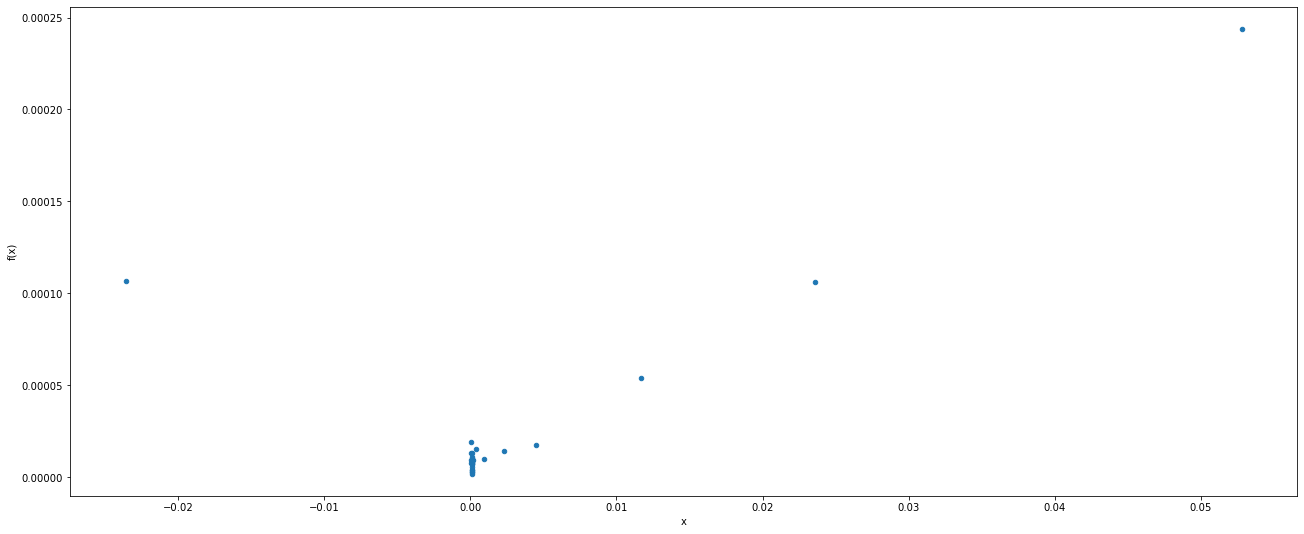

In [12]:
fdf.plot.scatter('x', 'f(x)')

### Smarter fit over one lens but all parameters

In [13]:
def unpack_geom_params(geom_params):
    fitted_geom_config = {'L1_rx': geom_params[0], 'L1_ry': geom_params[1]}
    return fitted_geom_config


def smart_build_telescope_to_fit(geom_params):
    """ Build telescope to fit from reference telescope
    """
    # Build telescope
    fitted_geom_config = unpack_geom_params(geom_params)
    fitted_telescope = tweak_optics.tweak_telescope(ref_telescope, fitted_geom_config)
    # Make refractive interfaces partially reflective
    tweak_optics.make_optics_reflective(fitted_telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])
    return fitted_telescope

res_store = []

def smart_compute_distance(geom_params):
    """ Callable function for the fit
    """
    # new telescope
    fitted_telescope = smart_build_telescope_to_fit(geom_params)
    fit_spots_df = simulator.run_and_analyze_simulation(fitted_telescope, geom_id=0, beam_config=fit_beam)
    # match ghosts
    match = match_ghosts(ref_spots_data_frame, fit_spots_df, radius_scale_factor=10)
    dist_2d = compute_2d_reduced_distance(match)
    fitted_geom_config = unpack_geom_params(geom_params)
    print(dist_2d, fitted_geom_config['L1_rx'], fitted_geom_config['L1_ry'])
    res_store.append([dist_2d, fitted_geom_config['L1_rx'], fitted_geom_config['L1_ry']])
    return dist_2d

def smart_fit_callback(geom_params):
    fitted_geom_config = unpack_geom_params(geom_params)
    #print(fitted_geom_config['L1_rx'], fitted_geom_config['L1_ry'])


In [14]:
# try to fit again
# https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead
nm_opts = {'disp': True, 'maxfev': 100, 'xatol': 1e-5, 'return_all': True, 'adaptive': True}
geom_params_0 = [0.05, -0.05]
res = minimize(smart_compute_distance, geom_params_0, method='Nelder-Mead', options=nm_opts,
              bounds=[(-0.1, 0.1), (-0.1, 0.1)], callback=smart_fit_callback)
print(res.nit, res.fun, res.x)

0.0003208107319017698 0.05 -0.05
0.0003254275969604412 0.052500000000000005 -0.05
0.0003256928249515521 0.05 -0.052500000000000005
0.00032256298839993355 0.052500000000000005 -0.0475
0.00030569740204909216 0.05 -0.0475
0.000297110434904981 0.04874999999999999 -0.046249999999999986
0.0003017627854658208 0.046249999999999986 -0.04874999999999999
0.0002838754109024362 0.04499999999999997 -0.04499999999999997
0.00027547129011873975 0.042499999999999954 -0.042499999999999954
0.0002740797892827527 0.04499999999999996 -0.03999999999999995
0.0002595733265161914 0.04437499999999994 -0.035624999999999934
0.0002230466146788219 0.03812499999999991 -0.0318749999999999
0.00018452324875640918 0.032812499999999856 -0.024687499999999862
0.0001767605708792671 0.03468749999999984 -0.017812499999999842
0.0001444217900936161 0.030781249999999788 -0.005468749999999786
9.063960399873636e-05 0.0192187499999997 0.005468750000000286
0.0001189704618996997 0.006640624999999581 0.026015625000000396
0.0001305072113

In [15]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.7224302424931138e-06
             x: [-1.191e-05 -4.529e-04]
           nit: 39
          nfev: 83
 final_simplex: (array([[-1.191e-05, -4.529e-04],
                       [-1.508e-05, -4.452e-04],
                       [-1.050e-05, -4.545e-04]]), array([ 1.722e-06,  5.113e-06,  1.495e-05]))
       allvecs: [array([ 5.000e-02, -5.000e-02]), array([ 5.000e-02, -5.000e-02]), array([ 4.875e-02, -4.625e-02]), array([ 4.875e-02, -4.625e-02]), array([ 4.250e-02, -4.250e-02]), array([ 4.437e-02, -3.562e-02]), array([ 3.281e-02, -2.469e-02]), array([ 3.078e-02, -5.469e-03]), array([ 1.922e-02,  5.469e-03]), array([ 1.922e-02,  5.469e-03]), array([ 1.922e-02,  5.469e-03]), array([ 1.922e-02,  5.469e-03]), array([ 1.922e-02,  5.469e-03]), array([ 1.116e-02,  1.743e-03]), array([ 1.116e-02,  1.743e-03]), array([ 1.116e-02,  1.743e-03]), array([-3.420e-03,  1.208e-03]), array([-3.420e-03

In [16]:
rdf = pd.DataFrame(res_store, columns=['distance', 'L1_rx', 'L1_ry'])
rdf.head()

,distance,L1_rx,L1_ry
0,0.000321,0.0500,-0.0500
1,0.000325,0.0525,-0.0500
2,0.000326,0.0500,-0.0525
3,0.000323,0.0525,-0.0475
4,0.000306,0.0500,-0.0475


<AxesSubplot: xlabel='L1_ry', ylabel='distance'>

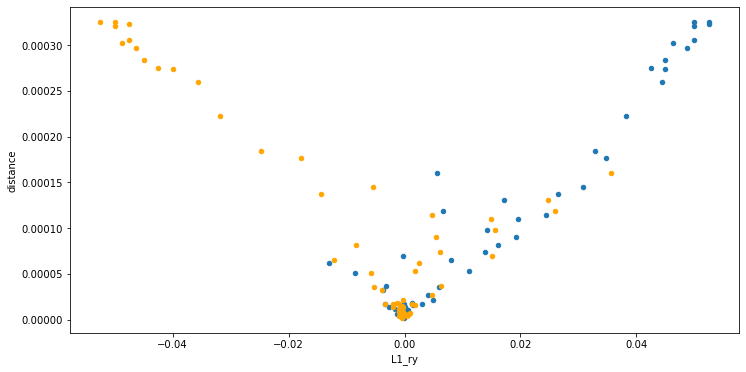

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
rdf.plot.scatter('L1_rx', 'distance', ax=ax)
rdf.plot.scatter('L1_ry', 'distance', ax=ax, color='orange')